# Data Extracts

In [507]:
import pandas as pd
import pickle
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


## 1. Cases by state (response)

In [23]:
# fetch US data from the NY Times github
covid_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")

# transform date to datetime object
covid_us["date"] = pd.to_datetime(covid_us["date"])

covid_us.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [70]:
def impute_missing_dates(df):
    '''
    function that imputes cases and deaths data for missing 
    dates with 0. returned df should have same MIN_DATE and 
    MAX_DATE for all states.
    '''
    # set min values
    MIN_DATE = df["date"].min()
    MIN_CASES = 0
    MIN_DEATHS = 0
    
    # iterate through all states
    imputed_data = []    
    for state in df["state"].unique():
        # build list of missing dates
        # https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
        sdate = MIN_DATE
        edate = df.loc[df["state"] == state]["date"].min()
        delta = edate - sdate 

        # iterate through all missing dates and impute case and 
        # death data
        for i in range(delta.days):
            day = sdate + datetime.timedelta(days=i)
            imputed_data.append({"date": day,
                                 "state": state,
                                 "fips": df.loc[df["state"]==state].iloc[0]["fips"],
                                 "cases": MIN_CASES,
                                 "deaths": MIN_DEATHS})

    # final cleanup
    new_df = pd.concat([pd.DataFrame(imputed_data), df])
    new_df = new_df.sort_values(by=["state", "date"]).reset_index().drop("index", axis=1)
    
    return new_df
    

In [71]:
# map state abbreviation
states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [72]:
# clean data by imputing missing dates and mapping abbreviations
covid_us_cleaned = impute_missing_dates(covid_us)
covid_us_cleaned["abbrev"] = covid_us_cleaned["state"].map(states_dict)

covid_us_cleaned.head()

,date,state,fips,cases,deaths,abbrev
0,2020-01-21,Alabama,1,0,0,AL
1,2020-01-22,Alabama,1,0,0,AL
2,2020-01-23,Alabama,1,0,0,AL
3,2020-01-24,Alabama,1,0,0,AL
4,2020-01-25,Alabama,1,0,0,AL


In [78]:
# dump to pickle file
pickle.dump( covid_us_cleaned, open("../data/us_state_cases_deaths.p", "wb" ))

## 2. Google search data

First, we will need to curate a list of Google search queries that may be predictive of coronavirus cases. We'll start by leveraging the Google Trends API to extract related queries to "coronavirus symptoms"

In [465]:
import pytrends
from pytrends.request import TrendReq

# connect 
pyt = TrendReq(hl='en-US', tz=300)

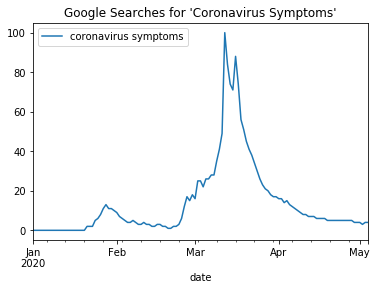

In [466]:
# build query: "coronavirus symptoms" searches starting at 2020
kw_list = ["coronavirus symptoms"]
now = datetime.datetime.now().strftime("%Y-%m-%d")
time_frame = f'''2020-01-01 {now}'''
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')

# interest over time
search_coronavirus = pyt.interest_over_time()
search_coronavirus.plot.line(y="coronavirus symptoms")
plt.title("Google Searches for 'Coronavirus Symptoms'");


Not entirely helpful - these are just different ways of saying "coronavirus symptoms". The only one that seems to give new information is: `first coronavirus symptoms`

In [169]:
# pyt.related_topics()[kw_list[0]]["top"]
# pyt.related_queries()["coronavirus symptoms"]["top"].iloc[:2]["query"].values
pyt.related_queries()["coronavirus symptoms"]["top"]

,query,value
0,symptoms of coronavirus,100
1,the coronavirus,37
2,symptoms of the coronavirus,25
3,the symptoms of the coronavirus,25
4,corona symptoms,16
5,corona,16
6,symptoms for coronavirus,16
7,what are coronavirus symptoms,15
8,what are symptoms of coronavirus,13
9,what are the coronavirus symptoms,12


In [216]:
# try with "first coronavirus symptoms"
kw_list = ["first coronavirus symptoms"]
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
# pyt.related_queries()[kw_list[0]]["top"]

# try with "do i have coronavirus"
kw_list = ["do i have coronavirus"]
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
# pyt.related_queries()[kw_list[0]]["top"]
# 
# try with "coronavirus testing near me"
kw_list = ["coronavirus symptoms"]
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
pyt.related_queries()[kw_list[0]]["rising"]



,query,value
0,the coronavirus,1031950
1,symptoms of the coronavirus,698350
2,the symptoms of the coronavirus,688450
3,corona symptoms,461400
4,corona,459200
5,symptoms for coronavirus,449800
6,what are coronavirus symptoms,421950
7,what are symptoms of coronavirus,362250
8,what are the coronavirus symptoms,348250
9,corona virus,338600


In [181]:
fever

,fever coronavirus,coronavirus symptoms fever,fever,isPartial
date,,,,
2020-01-01,0,0,39,False
2020-01-02,0,0,38,False
2020-01-03,0,0,39,False
2020-01-04,0,0,42,False
2020-01-05,0,0,38,False
...,...,...,...,...
2020-04-30,2,1,32,False
2020-05-01,2,1,32,False
2020-05-02,2,1,30,False


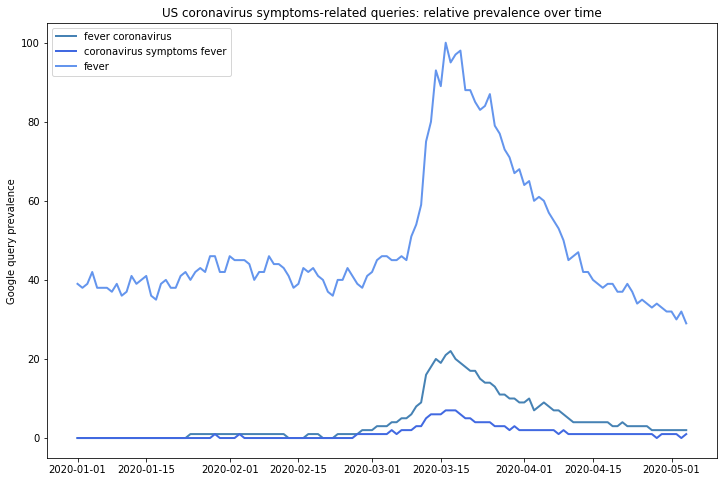

In [182]:
# try a few "fever" iterations
kw_list = ["fever coronavirus", "coronavirus symptoms fever", "fever"]
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
# pyt.related_queries()[kw_list[0]]["top"]
fever = pyt.interest_over_time().reset_index()

# now plot top related queries
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot("date", kw_list[0], data=fever, color='steelblue', linewidth=2)
plt.plot("date", kw_list[1], data=fever, color='royalblue', linewidth=2)
plt.plot("date", kw_list[2], data=fever, color='cornflowerblue', linewidth=2) 
# plt.plot("date", kw5_list[4], data=top5, color='lightsteelblue', linewidth=2)
plt.legend(loc="upper left")
plt.ylabel("Google query prevalence")
plt.title("US coronavirus fever-related queries: relative prevalence over time");


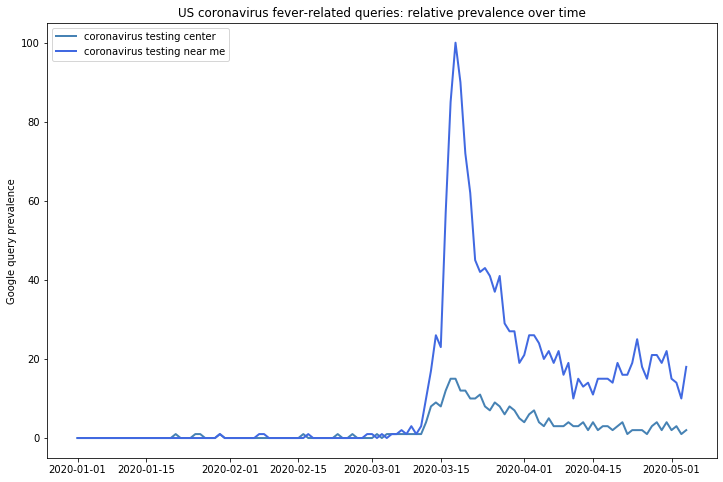

In [208]:
# try multiple symptoms
kw_list = ["coronavirus testing center", "coronavirus testing near me"]
pyt.build_payload(kw_list, cat=0, timeframe=time_frame, geo='US', gprop='')
# pyt.related_queries()[kw_list[0]]["top"]
fever = pyt.interest_over_time().reset_index()

# now plot top related queries
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot("date", kw_list[0], data=fever, color='steelblue', linewidth=2)
plt.plot("date", kw_list[1], data=fever, color='royalblue', linewidth=2)
# plt.plot("date", kw_list[2], data=fever, color='cornflowerblue', linewidth=2) 
# plt.plot("date", kw_list[3], data=fever, color='red', linewidth=2) 
# plt.plot("date", kw_list[4], data=fever, color='green', linewidth=2) 
# plt.plot("date", kw_list[5], data=fever, color='cornflowerblue', linewidth=2) 
plt.legend(loc="upper left")
plt.ylabel("Google query prevalence")
plt.title("US coronavirus fever-related queries: relative prevalence over time");


Note: to query more than 5 at a time, we'll have to string together multiple API calls, with one common benchmark term, to normalize to. For now let's just stick to 5 queries:
- fever
- shortness of breath
- loss of smell
- coronavirus testing near me
- do i have coronavirus

In [578]:
###########################
# method 1: fetch by state
###########################

# function that build kw_data frame
def fetch_query_data(kw_list):
    # instantiate state list and empty df to store results
    states = list(states_dict.values())
#     states = ["NY","HI"]
    state_queries = pd.DataFrame(columns = ["date", "abbrev"] + kw_list)
    state_queries = state_queries.set_index("date")

    print(f"Fetching data for the following queries: {kw_list}")
    # fetch all queries for each state in date range
    for state in states:
        try:
            pyt.build_payload(kw_list, cat=0, timeframe=f"2020-01-1 {now}", geo=f"US-{state}", gprop='')
        except:
            print(f"NOT FOUND: {state}")
            continue
        interest = pyt.interest_over_time().reset_index()
        interest["abbrev"] = state
        state_queries = pd.concat([interest, state_queries])

    # clean data types
    state_queries["date"] = pd.to_datetime(state_queries["date"])
    state_queries["coronavirus symptoms"] = subset["coronavirus symptoms"].astype(int)
    state_queries[kw_list] = state_queries[kw_list].apply(pd.to_numeric)
    state_queries = state_queries[["date", "abbrev"] + kw_list]
    
    # sort
    state_queries = state_queries.sort_values(by=["abbrev", "date"])
    
    return(state_queries)


def scale_to_benchmark(benchmark, kw_list, df_source, df_target):
    # set multiplier
    multiplier = (df_source["fever"].mean() / df_target["fever"].mean())
    
    # scale and convert to int
    df_target[kw_list] = df_target[kw_list].multiply(multiplier, axis="index")
    df_target = df_target.dropna()
    df_target[kw_list] = df_target[kw_list].astype(int)
    
    # sort
    df_target = df_target.sort_values(by=["abbrev", "date"])
    
    return df_target


In [579]:
# build queries 5 at a time, benchmark is fever
# start queries
benchmark = "flu"
kw_list = [benchmark, "shortness of breath", "loss of smell", "loss of taste", "cough"]
# kw_list = [benchmark, "fever"]
queries_master = fetch_query_data(kw_list)

Fetching data for the following queries: ['flu', 'shortness of breath', 'loss of smell', 'loss of taste', 'cough']


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: PR
NOT FOUND: VI


In [580]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "fever", "coronavirus testing near me", "do i have coronavirus", 
           "covid testing center"]
queries = fetch_query_data(kw_list)
# queries = scale_to_benchmark(benchmark, kw_list, queries_master, queries)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])

Fetching data for the following queries: ['flu', 'fever', 'coronavirus testing near me', 'do i have coronavirus', 'covid testing center']


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: PR
NOT FOUND: VI


In [581]:
# fetch new query and merge with preceding queries
kw_list = [benchmark, "chills", "sore throat", "fatigue", "chest pain"]
queries = fetch_query_data(kw_list)
# queries = scale_to_benchmark(benchmark, kw_list, queries_master, queries)

# merge with preceding
queries_master = pd.merge(queries_master, queries.drop(benchmark, axis=1), 
         how="left", on=["date", "abbrev"])



Fetching data for the following queries: ['flu', 'chills', 'sore throat', 'fatigue', 'chest pain']


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



NOT FOUND: AS
NOT FOUND: GU
NOT FOUND: MP
NOT FOUND: PR
NOT FOUND: VI


In [582]:
queries_master.describe()

,flu,shortness of breath,loss of smell,loss of taste,cough,fever,coronavirus testing near me,do i have coronavirus,covid testing center,chills,sore throat,fatigue,chest pain
count,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000,6375.000000
mean,28.598902,1.301647,0.215529,0.197176,8.722667,12.179608,0.362824,0.631373,0.160941,1.342431,4.582275,2.217412,2.965647
std,17.075312,1.637675,0.777776,0.654826,4.634181,6.111984,0.907365,1.345292,0.618823,1.684546,3.357540,2.196450,2.431925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,0.000000,0.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000
50%,23.000000,1.000000,0.000000,0.000000,8.000000,11.000000,0.000000,0.000000,0.000000,1.000000,4.000000,2.000000,3.000000
75%,36.000000,2.000000,0.000000,0.000000,11.000000,15.000000,0.000000,1.000000,0.000000,2.000000,6.000000,3.000000,4.000000
max,100.000000,20.000000,17.000000,9.000000,56.000000,54.000000,10.000000,16.000000,15.000000,23.000000,34.000000,26.000000,26.000000


In [557]:
# hi_master = queries_master.loc[queries_master["abbrev"] == "HI"]
# hi = queries.loc[queries["abbrev"] == "HI"]
# display(hi_master)
# hi
# # (hi_master["fever"].mean() / hi["fever"].mean())

# # hi["fever_norm"] = hi["fever"] * (hi_master["fever"].mean() / hi["fever"].mean())

# # hi["diff"] = hi["fever_norm"] - hi_master["fever"]

# # hi["diff"].describe()

In [558]:
# display(hi_master.iloc[1:10])
# display(hi.iloc[1:10])

In [559]:
# mult = hi_master["fever"].mean() / hi["fever"].mean()
# (hi["fever"] * mult).astype(int)

In [560]:
# # hi["fever_norm"] = hi["fever"] * (hi_master["fever"].mean() / hi["fever"].mean())

# # hi["diff"] = hi["fever_norm"] - hi_master["fever"]

# display(hi["diff"].describe())

# plt.hist(hi["diff"])

In [561]:
# queries_pre = queries
# display(queries_master)
# display(queries_pre)

# queries_post = scale_to_benchmark(benchmark, kw_list, queries_master, queries)

# display(queries_post)

In [562]:
# queries_pre = queries.copy()
# queries_post = queries.copy()
# scaler = MinMaxScaler(feature_range=(queries_master["fever"].min(), queries_master["fever"].max()))
# # queries_pre["flu_mult"] = queries_pre["flu"] / queries_pre["fever"]
# # queries_pre

# # queries_pre["fever_scaled"] = scaler.fit_transform(queries_pre["fever"])
# trans = scaler.fit_transform(queries_pre[kw_list])
# # queries_pre["fever_scaled"] = trans.reshape(-1)
# queries_post[kw_list] = trans

# display(queries_pre)
# display(queries_post)
# display(queries_master)
# # trans.reshape(-1).shape

# # queries_pre["fever"].shape

# # plt.hist(queries_pre["fever_scaled"])
# # plt.hist(queries_master["fever"])


In [583]:
# set multiplier
# multiplier = (queries_master[benchmark] / queries[benchmark]).fillna(0)
# multiplier
# queries_master[benchmark]
# queries[benchmark]

# scale and convert to int
# df_target[kw_list] = df_target[kw_list].multiply(multiplier, axis="index")
# df_target = df_target.dropna()
# df_target[kw_list] = df_target[kw_list].astype(int)

# display(queries)
# queries = scale_to_benchmark(benchmark, kw_list, queries_master, queries)
# queries_master

In [584]:
# dump to pickle file
pickle.dump(queries_master, open("../data/us_state_queries.p", "wb" ))

In [587]:
# queries covered in this extract
queries_master.drop(["date", "abbrev"], axis=1).columns

Index(['flu', 'shortness of breath', 'loss of smell', 'loss of taste', 'cough',
       'fever', 'coronavirus testing near me', 'do i have coronavirus',
       'covid testing center', 'chills', 'sore throat', 'fatigue',
       'chest pain'],
      dtype='object')

## 3. Google mobility trends data

In [588]:
# glory hallelujuh, Google published the data in CSV format...
mobility = pd.read_csv("../data/Global_Mobility_Report.csv")
mobility.head()


/Users/austinrochon/Documents/6.Harvard/harvard-coursework/ac209a/labs/lab1/cs109a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [598]:
queries_master

,date,abbrev,flu,shortness of breath,loss of smell,loss of taste,cough,fever,coronavirus testing near me,do i have coronavirus,covid testing center,chills,sore throat,fatigue,chest pain
0,2020-01-01,AK,12,12,0,0,24,12,0,0,0,0,24,12,0
1,2020-01-02,AK,11,0,0,0,11,0,0,0,0,0,22,0,0
2,2020-01-03,AK,21,0,0,0,11,21,0,0,0,0,0,0,11
3,2020-01-04,AK,12,0,0,0,23,34,0,0,0,0,0,11,23
4,2020-01-05,AK,23,0,0,0,0,12,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6370,2020-04-30,WY,13,6,0,0,10,6,0,0,0,0,0,6,0
6371,2020-05-01,WY,14,0,0,0,21,7,0,0,0,0,0,0,0
6372,2020-05-02,WY,12,0,0,0,0,16,0,0,0,0,0,0,0
6373,2020-05-03,WY,8,8,0,0,0,16,0,0,0,8,0,0,8


In [606]:
# US data - condense to state level
mobility_us = mobility.loc[(mobility["country_region_code"] == "US") & (pd.isnull(mobility["sub_region_2"]))]

# subset columns
mobility_us = mobility_us[["date", "sub_region_1", "retail_and_recreation_percent_change_from_baseline", 
                           "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline",
                           "transit_stations_percent_change_from_baseline", "workplaces_percent_change_from_baseline",
                           "residential_percent_change_from_baseline"]]

# rename state column
mobility_us = mobility_us.rename({'sub_region_1': 'state'}, axis=1)

# fetch abbrevation
mobility_us["abbrev"] = mobility_us["state"].map(states_dict)

# fill USA totals with appropriate labels
mobility_us["state"] = mobility_us["state"].fillna(value="United States")
mobility_us["abbrev"] = mobility_us["abbrev"].fillna(value="USA")

mobility_us.head()


,date,state,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,abbrev
94913,2020-02-15,United States,6.0,2.0,15.0,3.0,2.0,-1.0,USA
94914,2020-02-16,United States,7.0,1.0,16.0,2.0,0.0,-1.0,USA
94915,2020-02-17,United States,6.0,0.0,28.0,-9.0,-24.0,5.0,USA
94916,2020-02-18,United States,0.0,-1.0,6.0,1.0,0.0,1.0,USA
94917,2020-02-19,United States,2.0,0.0,8.0,1.0,1.0,0.0,USA


In [607]:
# dump to pickle file
pickle.dump(mobility_us, open("../data/us_state_mobility_data.p", "wb" ))